In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split    
from sklearn.metrics import accuracy_score,classification_report
import matplotlib.pyplot as plt
#Makes graph display in notebook
%matplotlib inline   

import seaborn as sns
import ppscore as pps

from sklearn.ensemble import RandomForestClassifier
    
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve

In [2]:
raw = pd.read_csv("bank-additional-full.csv", sep = ';')

In [3]:
print(raw.columns)
df = raw.copy()

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')


In [4]:
#raw.to_excel('data.xlsx')

In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
df.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [8]:
df.loc[df.duplicated(),'y'].value_counts()

no     11
yes     1
Name: y, dtype: int64

In [9]:
#There are 2158 duplicates existing in this dataframe. We are going to remove these duplicates

In [10]:
df = df.drop_duplicates(keep='last')

## Feature selection

In [11]:
for i in df.columns:
    print(i, '    ' , len(df[i].unique()))
    print(i, '--->\n' , df[i].value_counts())
    print('\n\n')

age      78
age --->
 31    1947
32    1845
33    1833
36    1779
35    1758
      ... 
89       2
91       2
87       1
94       1
95       1
Name: age, Length: 78, dtype: int64



job      12
job --->
 admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64



marital      4
marital --->
 married     24921
single      11564
divorced     4611
unknown        80
Name: marital, dtype: int64



education      8
education --->
 university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: education, dtype: int64



default      3
default --->
 no         32577
unknown     8596


Text(0.5, 1.05, 'Correlation Matrix')

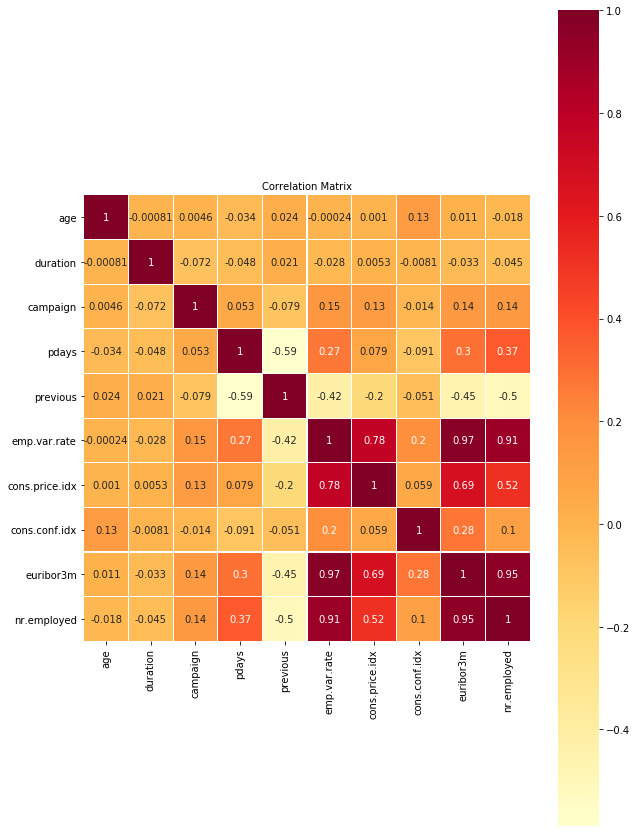

In [12]:
f, ax = plt.subplots(figsize=(10,15))
sns.heatmap(df.corr(), cmap="YlOrRd", square=True, ax=ax, annot=True, linewidth=0.1)
plt.title("Correlation Matrix", y=1.05, size=10)

In [13]:
df = df.drop(['duration','pdays'], axis = 1)

In [14]:
df['default'].replace('unknown',np.nan).isnull().sum()

8596

In [15]:
df = df.drop(['default'], axis = 1)

## Impute Unknown values

In [16]:
cat_cols = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

In [17]:
df.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y'],
      dtype='object')

## Derived Features

In [18]:
camp_grp = df.groupby(['campaign','y']).size().reset_index(name = 'count')
camp_grp = camp_grp.pivot_table(index = ['campaign'],columns=['y']).reset_index().fillna(0)
camp_grp = pd.concat((camp_grp['campaign'],camp_grp['count']),axis = 1)
camp_grp['total'] = camp_grp['no'] + camp_grp['yes']
camp_grp['yes_perc'] = (camp_grp['yes'] / camp_grp['total'] )*100

def get_camp_yes_perc(x):
    return camp_grp.loc[camp_grp['campaign'] == x,'yes_perc'].iloc[0]

In [19]:
df['camp_yes_perc'] = df['campaign'].apply(get_camp_yes_perc)

In [20]:
#df[['campaign','camp_yes_perc']].tail()

### Age, Job, marital, education

In [21]:
df['y_dummy'] = df['y']

In [22]:
df['y'] = df['y'].replace('no',0).replace('yes',1)
df['Y_yes'] = df.groupby(['age','job','marital','education','loan','housing','emp.var.rate','cons.price.idx'])['y'].transform('sum')
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,camp_yes_perc,y_dummy,Y_yes
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,13.037314,no,0
1,57,services,married,high.school,no,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,13.037314,no,0
2,37,services,married,high.school,yes,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,13.037314,no,0
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,13.037314,no,0
4,56,services,married,high.school,no,yes,telephone,may,mon,1,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,13.037314,no,0


In [23]:
df['y_dummy'] = df['y_dummy'].replace('no',1).replace('yes',0)
df['Y_no'] = df.groupby(['age','job','marital','education','loan','housing','emp.var.rate','cons.price.idx'])['y_dummy'].transform('sum')
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,camp_yes_perc,y_dummy,Y_yes,Y_no
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,...,1.1,93.994,-36.4,4.857,5191.0,0,13.037314,1,0,2
1,57,services,married,high.school,no,no,telephone,may,mon,1,...,1.1,93.994,-36.4,4.857,5191.0,0,13.037314,1,0,1
2,37,services,married,high.school,yes,no,telephone,may,mon,1,...,1.1,93.994,-36.4,4.857,5191.0,0,13.037314,1,0,11
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,...,1.1,93.994,-36.4,4.857,5191.0,0,13.037314,1,0,1
4,56,services,married,high.school,no,yes,telephone,may,mon,1,...,1.1,93.994,-36.4,4.857,5191.0,0,13.037314,1,0,2


In [24]:
df = df.drop(['y_dummy'], axis = 1)

In [25]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
camp_yes_perc     0
Y_yes             0
Y_no              0
dtype: int64

## Monthly indicators pattern
## social and economic context attributes

#### 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
#### 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
#### 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
#### 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
#### 20 - nr.employed: number of employees - quarterly indicator (numeric)

#### Some columns are in monthly pattern, some are in quarterly and some are in daily. Convert all to monthly.

In [26]:
df['emp.var.rate_per_month'] = df['emp.var.rate']/4
df['euribor3m_per_month'] = df['euribor3m']*30
df['nr.employed_per_month'] = df['nr.employed']/4

In [27]:
df['y_dummy_1'] = df['y'] #created temp for manipulation
df['y_dummy_2'] = df['y']

In [28]:
df['y_dummy_1'] = df['y_dummy_1'].replace('no',0).replace('yes',1)
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,...,nr.employed,y,camp_yes_perc,Y_yes,Y_no,emp.var.rate_per_month,euribor3m_per_month,nr.employed_per_month,y_dummy_1,y_dummy_2
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,...,5191.0,0,13.037314,0,2,0.275,145.71,1297.75,0,0
1,57,services,married,high.school,no,no,telephone,may,mon,1,...,5191.0,0,13.037314,0,1,0.275,145.71,1297.75,0,0
2,37,services,married,high.school,yes,no,telephone,may,mon,1,...,5191.0,0,13.037314,0,11,0.275,145.71,1297.75,0,0
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,...,5191.0,0,13.037314,0,1,0.275,145.71,1297.75,0,0
4,56,services,married,high.school,no,yes,telephone,may,mon,1,...,5191.0,0,13.037314,0,2,0.275,145.71,1297.75,0,0


In [29]:
df['SocialEco_yes'] = df.groupby(['job','emp.var.rate_per_month','cons.price.idx','cons.conf.idx','euribor3m_per_month','nr.employed_per_month'])['y_dummy_1'].transform('sum')

In [30]:
df['y_dummy_2'] = df['y_dummy_2'].replace('no',1).replace('yes',0)

In [31]:
df['SocialEco_no'] = df.groupby(['job','emp.var.rate_per_month','cons.price.idx','cons.conf.idx','euribor3m_per_month','nr.employed_per_month'])['y_dummy_2'].transform('sum')

In [32]:
df = df.drop(['y_dummy_1', 'y_dummy_2'], axis = 1)

In [33]:
df = df.drop(['emp.var.rate','euribor3m', 'nr.employed'], axis = 1)

In [34]:
df['y'] = df['y'].replace('no',0).replace('yes',1)
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,...,cons.conf.idx,y,camp_yes_perc,Y_yes,Y_no,emp.var.rate_per_month,euribor3m_per_month,nr.employed_per_month,SocialEco_yes,SocialEco_no
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,1,...,-36.4,0,13.037314,0,2,0.275,145.71,1297.75,2,2
1,57,services,married,high.school,no,no,telephone,may,mon,1,...,-36.4,0,13.037314,0,1,0.275,145.71,1297.75,10,10
2,37,services,married,high.school,yes,no,telephone,may,mon,1,...,-36.4,0,13.037314,0,11,0.275,145.71,1297.75,10,10
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,1,...,-36.4,0,13.037314,0,1,0.275,145.71,1297.75,11,11
4,56,services,married,high.school,no,yes,telephone,may,mon,1,...,-36.4,0,13.037314,0,2,0.275,145.71,1297.75,10,10


In [35]:
df.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'previous', 'poutcome',
       'cons.price.idx', 'cons.conf.idx', 'y', 'camp_yes_perc', 'Y_yes',
       'Y_no', 'emp.var.rate_per_month', 'euribor3m_per_month',
       'nr.employed_per_month', 'SocialEco_yes', 'SocialEco_no'],
      dtype='object')

## Imputations

In [36]:
df_copy = df.copy()

In [37]:
df['marital'] = df['marital'].replace('unknown',np.nan)


In [38]:
df['marital'] = df.groupby(['age'], sort=False)['marital'].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [39]:
df['marital'].isna().sum()

0

In [40]:
df.isna().sum()

age                       0
job                       0
marital                   0
education                 0
housing                   0
loan                      0
contact                   0
month                     0
day_of_week               0
campaign                  0
previous                  0
poutcome                  0
cons.price.idx            0
cons.conf.idx             0
y                         0
camp_yes_perc             0
Y_yes                     0
Y_no                      0
emp.var.rate_per_month    0
euribor3m_per_month       0
nr.employed_per_month     0
SocialEco_yes             0
SocialEco_no              0
dtype: int64

In [41]:
df = df.replace('unknown',np.nan)

In [42]:
#median for numeric and mode for categorical
f = lambda x: x.median() if np.issubdtype(x.dtype, np.number) else x.mode().iloc[0]

In [43]:
df['job'] = df.groupby(['age'], sort=False)['job'].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [44]:
df['education'].value_counts()

university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
illiterate                18
Name: education, dtype: int64

In [45]:
df['education'] = raw['education']

In [46]:
df.loc[(df['education'] == 'unknown') , df.columns.isin(['education', 'job', 'age'])]#['age'].value_counts()

,age,job,education
7,41,blue-collar,unknown
10,41,blue-collar,unknown
26,59,technician,unknown
30,46,admin.,unknown
31,59,technician,unknown
...,...,...,...
41118,34,technician,unknown
41120,60,admin.,unknown
41122,34,technician,unknown
41135,54,technician,unknown


In [47]:
df['education'] = df.groupby(['age','job'], sort=False)['education'].apply(lambda x: x.replace('unknown',x.mode().iloc[0]))

In [48]:
# Still there are 103 unknown value counts
df['education'].value_counts()

university.degree      12640
high.school             9769
basic.9y                6371
professional.course     5437
basic.4y                4550
basic.6y                2291
unknown                  100
illiterate                18
Name: education, dtype: int64

#### When we look at the still unknown education records, these records are not having any atleast 1 value when we group by age & Job
#### So we can just group by age and replace it with mode.

In [49]:
df['education'] = df.groupby(['age'], sort=False)['education'].apply(lambda x: x.replace('unknown',x.mode().iloc[0]))

In [50]:
df['education'].value_counts()

university.degree      12694
high.school             9772
basic.9y                6371
professional.course     5437
basic.4y                4559
basic.6y                2291
unknown                   34
illiterate                18
Name: education, dtype: int64

#### Still 34 records exists as unknown.
#### Lets look at the records first

In [51]:
df.loc[(df['education'] == 'unknown') , df.columns.isin(['education', 'job', 'age'])]#['age'].value_counts()

,age,job,education
28902,19,student,unknown
28979,19,student,unknown
29052,19,student,unknown
29072,19,student,unknown
29136,19,student,unknown
29401,19,student,unknown
29407,19,student,unknown
29609,19,student,unknown
29646,19,student,unknown
29707,19,student,unknown


In [52]:
df['education'] = df.groupby(['job'], sort=False)['education'].apply(lambda x: x.replace('unknown',x.mode().iloc[0]))

In [53]:
df['education'].value_counts()

university.degree      12694
high.school             9802
basic.9y                6371
professional.course     5437
basic.4y                4563
basic.6y                2291
illiterate                18
Name: education, dtype: int64

#### Default column is having only 3 yes values and maximum No values and 8597 are null/unknown
#### Verified whether the 3 yes values are having any correlation with (target) Y's Yes value. But all these default - Yes values are having No value in target variable. 
#### So this column will not make any correlation with Y value directly.
#### We can remove this column but this column may make any correlation with target variable in combination with another column.
#### Thus we can simply impute this column with No values

In [54]:
#df['default'] = df['default'].fillna('no')

#### When comparing with job, education, the no counts are 3 times higher than yes counts.
#### So we can simply impute it with No

In [55]:
df['loan'] = df['loan'].fillna('no')

#### When comparing with job, education, the yes counts are higher than no counts.
#### So we can simply impute it with yes

In [56]:
df['housing'].value_counts()

yes    21571
no     18615
Name: housing, dtype: int64

In [57]:
df['housing'] = df['housing'].fillna('yes')

##### ========================= finished imputations ========================

In [58]:
cat_cols = ['job','marital','education','housing','loan','contact','month','day_of_week','poutcome']

In [59]:
df_copy = df.copy()

In [60]:
df_copy = df_copy.drop(cat_cols, axis = 1)

In [61]:
dummy_job = pd.get_dummies(df['job'], prefix='job')
dummy_marital = pd.get_dummies(df['marital'], prefix='marital')
dummy_education = pd.get_dummies(df['education'], prefix='edu')
dummy_housing = pd.get_dummies(df['housing'], prefix='hous')
dummy_loan = pd.get_dummies(df['loan'], prefix='loan')
dummy_contact = pd.get_dummies(df['contact'], prefix='contact')
dummy_month = pd.get_dummies(df['month'], prefix='month')
dummy_day_of_week = pd.get_dummies(df['day_of_week'], prefix='dow')
dummy_poutcome = pd.get_dummies(df['poutcome'], prefix='outcome')

In [62]:
df_with_dummy = pd.concat([dummy_job, dummy_marital, dummy_education,  dummy_housing, dummy_loan,
                           dummy_contact,df_copy], axis=1)

In [63]:
df_with_dummy.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'edu_basic.4y', 'edu_basic.6y',
       'edu_basic.9y', 'edu_high.school', 'edu_illiterate',
       'edu_professional.course', 'edu_university.degree', 'hous_no',
       'hous_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'age', 'campaign', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'y', 'camp_yes_perc', 'Y_yes', 'Y_no',
       'emp.var.rate_per_month', 'euribor3m_per_month',
       'nr.employed_per_month', 'SocialEco_yes', 'SocialEco_no'],
      dtype='object')

##### ========================= finished encoding ========================

In [64]:
df_with_dummy['y'].replace('no',0)
df_with_dummy['y'].replace('yes',1)

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41176, dtype: int64

Text(0.5, 1.05, 'Correlation Matrix')

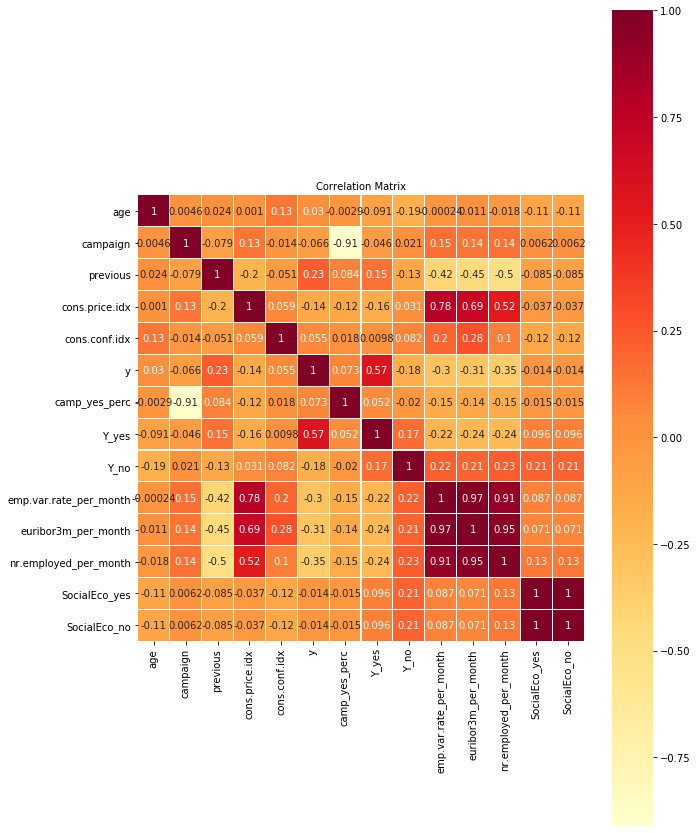

In [65]:
f, ax = plt.subplots(figsize=(10,15))
sns.heatmap(df.corr(), cmap="YlOrRd", square=True, ax=ax, annot=True, linewidth=0.1)
plt.title("Correlation Matrix", y=1.05, size=10)

In [66]:
df_with_dummy.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'edu_basic.4y', 'edu_basic.6y',
       'edu_basic.9y', 'edu_high.school', 'edu_illiterate',
       'edu_professional.course', 'edu_university.degree', 'hous_no',
       'hous_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'age', 'campaign', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'y', 'camp_yes_perc', 'Y_yes', 'Y_no',
       'emp.var.rate_per_month', 'euribor3m_per_month',
       'nr.employed_per_month', 'SocialEco_yes', 'SocialEco_no'],
      dtype='object')

In [67]:
#df_with_dummy = df_with_dummy.drop(['euribor3m', 'nr.employed'], axis = 1)

In [68]:

y = df_with_dummy.pop('y')

#### Convert target variable's values into 0s and 1s

In [69]:
y.value_counts()

0    36537
1     4639
Name: y, dtype: int64

In [70]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(df_with_dummy,y)

selected_feat= df_with_dummy.columns[(sel.get_support())]
print(len(selected_feat))

print(selected_feat)


9
Index(['age', 'campaign', 'camp_yes_perc', 'Y_yes', 'Y_no',
       'euribor3m_per_month', 'nr.employed_per_month', 'SocialEco_yes',
       'SocialEco_no'],
      dtype='object')


In [71]:
#pd.Series(sel.estimator_,).hist()

In [72]:
# Train & Test split
x_train,x_test,y_train,y_test = train_test_split(df_with_dummy, y, train_size = 0.8, random_state=42)

In [73]:
y_test.value_counts()

0    7266
1     970
Name: y, dtype: int64

In [74]:
df_with_dummy.columns

Index(['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'edu_basic.4y', 'edu_basic.6y',
       'edu_basic.9y', 'edu_high.school', 'edu_illiterate',
       'edu_professional.course', 'edu_university.degree', 'hous_no',
       'hous_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'age', 'campaign', 'previous', 'cons.price.idx',
       'cons.conf.idx', 'camp_yes_perc', 'Y_yes', 'Y_no',
       'emp.var.rate_per_month', 'euribor3m_per_month',
       'nr.employed_per_month', 'SocialEco_yes', 'SocialEco_no'],
      dtype='object')

## Apply SMOTE

In [75]:
from imblearn.over_sampling import SMOTE

In [76]:
x_train.shape

(32940, 40)

In [77]:
sm =SMOTE()

In [78]:
x_train_sm,y_train_sm = sm.fit_sample(x_train,y_train)

In [79]:
x_train.shape, x_train_sm.shape

((32940, 40), (58542, 40))

In [80]:
x_train = x_train_sm
y_train = y_train_sm

## Scaling

In [81]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
x_train = std.fit_transform(x_train)
x_test = std.transform(x_test)

In [82]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()



Random Forest for Ensemble - Test Confusion Matrix

 Predicted     0    1
Actuall             
0          6743  523
1            93  877

Random Forest for Ensemble - Test accuracy 0.925

Random Forest for Ensemble - Test Classification Report
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      7266
           1       0.63      0.90      0.74       970

    accuracy                           0.93      8236
   macro avg       0.81      0.92      0.85      8236
weighted avg       0.94      0.93      0.93      8236

AUC Score: 0.98


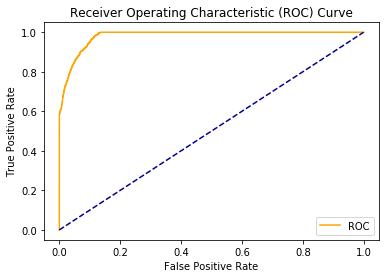

In [90]:
# Classifier 2
from sklearn.ensemble import RandomForestClassifier
clf3_rf_fit = RandomForestClassifier(n_estimators=1500,criterion="gini",max_depth=6,
                                min_samples_split=2,min_samples_leaf=1)
clf3_rf_fit.fit(x_train,y_train)       

print ("\n\nRandom Forest for Ensemble - Test Confusion Matrix\n\n",pd.crosstab(y_test,clf3_rf_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nRandom Forest for Ensemble - Test accuracy",round(accuracy_score(y_test,clf3_rf_fit.predict(x_test)),3))
print ("\nRandom Forest for Ensemble - Test Classification Report\n",classification_report(y_test,clf3_rf_fit.predict(x_test)))

pred_prob = clf3_rf_fit.predict_proba(x_test)
probs = pred_prob[:, 1]

auc = roc_auc_score(y_test, probs)
print('AUC Score: %.2f' % auc)

fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)